[(array([[ 54.372513, 215.51125 ]], dtype=float32), array([[674.11285, 377.47174]], dtype=float32)), (array([[ 61.03929, 407.39633]], dtype=float32), array([[818.82385, 564.6319 ]], dtype=float32)), (array([[ 89.825836, 641.58704 ]], dtype=float32), array([[873.9437 , 838.34827]], dtype=float32)), (array([[ 94.578285, 385.9115  ]], dtype=float32), array([[920.82605, 441.81732]], dtype=float32)), (array([[133.70651, 820.70654]], dtype=float32), array([[651.1988, 774.0697]], dtype=float32)), (array([[ 133.7282, 1094.2627]], dtype=float32), array([[651.1988, 774.0697]], dtype=float32)), (array([[ 133.7282, 1094.2627]], dtype=float32), array([[651.1988, 774.0697]], dtype=float32)), (array([[156.66515, 662.9736 ]], dtype=float32), array([[291.9176, 823.4632]], dtype=float32)), (array([[162.9352 , 839.33746]], dtype=float32), array([[332.28677, 138.90271]], dtype=float32)), (array([[ 182.86615, 1275.6537 ]], dtype=float32), array([[1143.9688 ,   59.91836]], dtype=float32))]


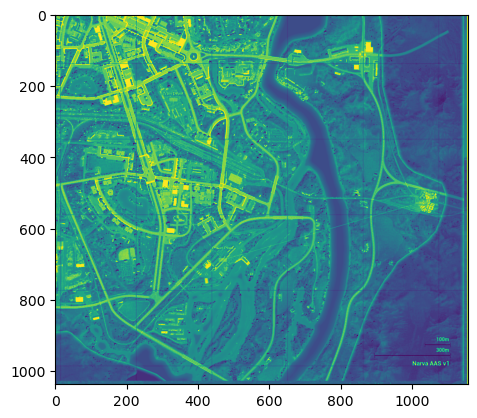

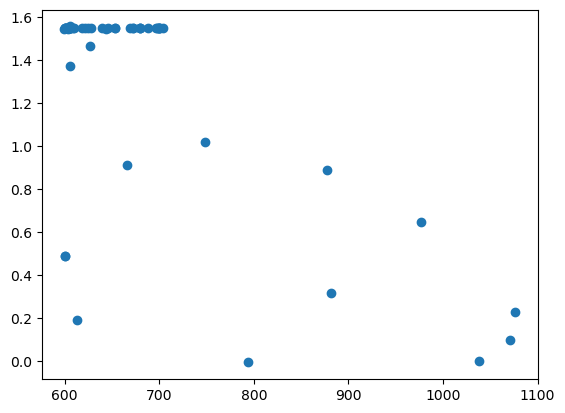

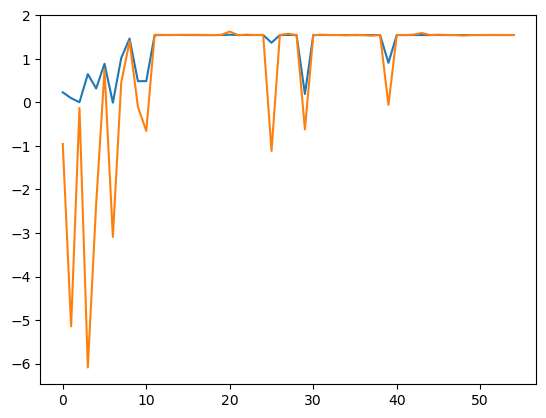

In [2]:
import numpy as np
import pandas as pd
import cv2 as cv
import scipy.stats as stats
from matplotlib import pyplot as plt

%matplotlib inline

MIN_MATCH_COUNT = 10
base = cv.imread('work/narva.png', cv.IMREAD_GRAYSCALE)  # queryImage

def correlate(segment_image):
    # Initiate SIFT detector
    sift = cv.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(base, None)
    kp2, des2 = sift.detectAndCompute(segment_image, None)
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)
    if len(good) > MIN_MATCH_COUNT:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()
        h, w = base.shape
        pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
        dst = cv.perspectiveTransform(pts, M)
        segment_image = cv.polylines(segment_image, [np.int32(dst)], True, 255, 3, cv.LINE_AA)
        print([(s,d) for s,d in zip(src_pts, dst_pts)][:10])
    else:
        print("Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT))
        matchesMask = None


    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
     singlePointColor = None,
     matchesMask = matchesMask, # draw only inliers
     flags = 2)
    img3 = cv.drawMatches(base, kp1, segment_image, kp2, good, None, **draw_params)
    # find center of segment_image, and superimpose on base

    center = segment_image.shape[0] // 2, segment_image.shape[1] // 2
    plt.imshow(segment_image), plt.show()
    segment_image = cv.circle(segment_image, center, 5, (0,0,255), -1)

    # find average scaling factor

    def pts_diff(pts):
        for i in range(pts.shape[0]):
            p1, p2 = pts[i][0], pts[(i + 100) % pts.shape[0]][0]
            yield (p1[0] - p2[0]), (p1[1] - p2[1])

    diffs = [(s,d) for s, d in zip(pts_diff(src_pts), pts_diff(dst_pts)) if s[0] > 2 and s[1] > 2]
    factors = [(diff_d[0] / diff_s[0], diff_d[1] / diff_s[1]) for diff_s, diff_d in diffs]
    factors_x =[f[0] for f in factors]
    diffs_x = [d[0][0] for d in diffs]
    plt.scatter(diffs_x, factors_x)
    plt.show()

    # print("factors:")
    # for f in factors[20:40]:
    #     print(f)
    #
    plt.plot(factors)
    plt.show()
    plt.close()
    #
    # factors = pd.DataFrame(factors)
    # print(factors)
    # z = stats.zscore(factors)
    # factors.plot()
    # factors_clean = factors[(z<3).all(axis=1)]
    # factors_clean.plot()
    # plt.show()
    # plt.close()
    #
    # plt.imshow(segment_image), plt.show()
    # plt.imshow(img3, 'gray'),plt.show()
    #
correlate(cv.imread('work/narva_sub5.png', cv.IMREAD_GRAYSCALE))
# correlate(cv.imread('work/narva_sub3.png', cv.IMREAD_GRAYSCALE))
# correlate(cv.imread('work/narva_sub4.png', cv.IMREAD_GRAYSCALE))

